In [1]:
import time

from IPython.display import HTML

import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
import matplotlib.ticker as ticker
import torch
from tqdm import tqdm

from threedeequadsim import quadsim, controller, trajectory, experiments, utils

import importlib
importlib.reload(controller)
importlib.reload(quadsim)
importlib.reload(trajectory)

<module 'threedeequadsim.trajectory' from 'c:\\Users\\mtoc1\\Documents\\github\\Online-Meta-Adaptive-Control-OMAC-Algorithm\\quadsim\\threedeequadsim\\trajectory.py'>

In [2]:
test_name = 'hover' # {'hover', 'fig-8'}

In [3]:
nametag = test_name + 'test'

In [4]:
folder = './plots/' + time.strftime('%Y-%m-%d') + '/' + nametag + '/'
if not os.path.isdir(folder):
    os.makedirs(folder)
    print('Created data folder ' + folder)

In [5]:
def savefig(plottag):
    plt.savefig(folder + plottag + '.png', bbox_inches='tight')
# def savefig(plottag):
#     pass
xyz = ['x', 'y', 'z']

In [6]:
eta_a = 0.005

eta_A_convex = 0.0005
eta_A_biconvex = 0.0002
eta_A_deep = 0.05

dim_a = 50
dim_A = 100
layer_sizes = (75, 150)

feature_freq = 0.5

In [7]:
q_kwargs = {
    'Vwind' : np.array((5.0, 0, 0)),            # mean wind speed
    'wind_model': 'iid-uniform',                # {'iid', 'random-walk'}
    # 'Vwind_cov' : 7.5,                        # how quickly the wind changes
    # 'wind_constraint' : 'hard',               # 'hard' wind constraint limits wind speed to be within Vwind_gust of the mean speed
    'Vwind_gust' : np.array((5.0, 0., 2.5)),    # for hard wind constrant, wind speed is in the range Vwind +/- Vwind_gust
    'wind_update_period' : 2.0,                 # seconds between wind speed changes
    't_stop' : 60.,
}

In [8]:
CTRLS = [
    controller.Baseline(),
    controller.MetaAdaptBaseline(eta_a_base=eta_a, dim_a=dim_a, feature_freq=feature_freq),
    controller.MetaAdaptConvex(eta_a_base=eta_a, eta_A_base=eta_A_convex, dim_a=dim_a, dim_A=dim_A, feature_freq=feature_freq),
    controller.MetaAdaptBiconvex(eta_a_base=eta_a, eta_A_base=eta_A_biconvex, dim_a=dim_a, dim_A=dim_A, feature_freq=feature_freq),
    controller.MetaAdaptDeep(eta_a_base=eta_a, eta_A_base=eta_A_deep, dim_a=dim_a, layer_sizes=layer_sizes),
    controller.Omniscient()
]

In [9]:
if test_name == 'hover':
    T = trajectory.hover

    t_kwargs = {
        'pd' : np.zeros(3)
    }

elif test_name == 'fig-8':
    T = trajectory.fig8
    t_kwargs = {
        'T': np.pi * 1.5
    }

In [10]:
Data = []
num_trials = 50
starter_seed = 115
np.random.seed(starter_seed)
seeds = np.random.randint(np.iinfo(np.uint).max, size=(num_trials,), dtype=np.uint)
print(seeds)

for c in CTRLS:
    Data.append([])
    
    for seed in seeds:    
        q = quadsim.QuadrotorWithSideForce(**q_kwargs, )    # create a quadrotor object
        t = T(**t_kwargs)                                   # create a trajectory object and initialize the trajectory

        data = q.run(trajectory=t, controller=c, seed=seed) # run the simulation
                                                            # note: this will set the seed, call c.reset_controller(), then reset the seed again
        Data[-1].append(data)                               # save the results

[ 842210066 1252270496 3018393071 1595393506 1776792454 2398697104
 2477340379   11494286 3126185205 2124508385  818364831   69689897
 2461523902 1976440878 2637936908 3762146113 2336410723  597880839
 3404341390 1601641585 2334605630 2313682532 1727285149 1903907449
  350412971 3029673602 3074151807 2107063126 4276200817 3132254356
  612152631 1290282885  657207633  666474484  885682400 1072567615
 4021588685 4050270453 3444695699 1387258015 3904062082 1500190112
 4153320081 1271597107 3341780157 2290844523 3835157492 4155455563
 1339922475 3776341673]


6001it [01:15, 79.29it/s]                            
6001it [01:15, 79.86it/s]                            
6001it [01:15, 79.10it/s]
6001it [01:15, 79.95it/s]                            
6001it [01:14, 80.26it/s]                            
6001it [01:15, 79.48it/s]                            
6001it [01:14, 80.24it/s]
6001it [01:16, 78.91it/s]                            
6001it [01:14, 80.23it/s]                            
6001it [01:17, 77.48it/s]                            
6001it [01:15, 79.50it/s]                            
6001it [01:15, 79.53it/s]                            
6001it [01:14, 80.25it/s]                            
6001it [01:15, 79.71it/s]                            
6001it [01:15, 79.02it/s]                            
6001it [01:15, 79.99it/s]                            
6001it [01:14, 80.05it/s]                            
6001it [01:15, 80.01it/s]
6001it [01:15, 79.83it/s]                            
6001it [01:15, 79.87it/s]                            
6001

In [11]:
print('%-20s, %6s, %15s' % ('Controller', 'ACE', 'Steady State ACE'))

stats = []
for c, data in zip(CTRLS, Data): # this doesn't work if you only have one controller...
    stats.append([0., 0.])
    for d in data:
        err = experiments.get_error(d['X'], d['pd'])
        err_ss = experiments.get_error(d['X'], d['pd'], istart=1000) # ss=steady state
        print('%-20s, %5.4f, %5.4f' % ('-----' + c._name, err['meanerr'], err_ss['meanerr']))
        stats[-1][0] += err['meanerr']
        stats[-1][1] += err_ss['meanerr']
    stats[-1][0] /= len(data)
    stats[-1][1] /= len(data)
    print('%-20s, %5.4f, %5.4f' % (c._name, stats[-1][0], stats[-1][1]))

Controller          ,    ACE, Steady State ACE
-----pid            , 0.2049, 0.1656
-----pid            , 0.2084, 0.1634
-----pid            , 0.1509, 0.1508
-----pid            , 0.2079, 0.1925
-----pid            , 0.1871, 0.1620
-----pid            , 0.1944, 0.1633
-----pid            , 0.2365, 0.2293
-----pid            , 0.2024, 0.1804
-----pid            , 0.2262, 0.1954
-----pid            , 0.1965, 0.1574
-----pid            , 0.2161, 0.1885
-----pid            , 0.1877, 0.1741
-----pid            , 0.1752, 0.1556
-----pid            , 0.1997, 0.1598
-----pid            , 0.2209, 0.2055
-----pid            , 0.1905, 0.1674
-----pid            , 0.1711, 0.1382
-----pid            , 0.2054, 0.1747
-----pid            , 0.2001, 0.1717
-----pid            , 0.1710, 0.1282
-----pid            , 0.2072, 0.1906
-----pid            , 0.1904, 0.1539
-----pid            , 0.1818, 0.1522
-----pid            , 0.2048, 0.1777
-----pid            , 0.1823, 0.1504
-----pid            , 0.2102

In [32]:
importlib.reload(experiments)
options = q_kwargs.copy()
for key in options:
    print(key, options[key])
    if isinstance(options[key], np.ndarray):
        print('found ndarray')
        options[key] = options[key].tolist()
options['eta_a'] = eta_a
options['eta_A_convex'] = eta_A_convex
options['eta_A_biconvex'] = eta_A_biconvex
options['eta_A_deep'] = eta_A_deep

options['dim_a'] = dim_a
options['dim_A'] = dim_A
options['layer_sizes'] = layer_sizes

options['feature_freq'] = feature_freq

for j, data in enumerate(Data):
    for k, d in enumerate(data):
        d['name'] = CTRLS[j]._name + '_%02d' % k
experiments.save(Data, options=options, testname='test')

Vwind [5. 0. 0.]
found ndarray
wind_model iid-uniform
Vwind_gust [5.  0.  2.5]
found ndarray
wind_update_period 2.0
t_stop 60.0
Created data folder data/experiments/test/
  saving pid_00 to folder data/experiments/test/pid_00/
  saving pid_01 to folder data/experiments/test/pid_01/
  saving pid_02 to folder data/experiments/test/pid_02/
  saving pid_03 to folder data/experiments/test/pid_03/
  saving pid_04 to folder data/experiments/test/pid_04/
  saving pid_05 to folder data/experiments/test/pid_05/
  saving pid_06 to folder data/experiments/test/pid_06/
  saving pid_07 to folder data/experiments/test/pid_07/
  saving pid_08 to folder data/experiments/test/pid_08/
  saving pid_09 to folder data/experiments/test/pid_09/
  saving pid_10 to folder data/experiments/test/pid_10/
  saving pid_11 to folder data/experiments/test/pid_11/
  saving pid_12 to folder data/experiments/test/pid_12/
  saving pid_13 to folder data/experiments/test/pid_13/
  saving pid_14 to folder data/experiments/te

In [12]:
color = ((1,0,0), (0,1,0), (0,0,1)) # colors for x, y and z directions

In [13]:
importlib.reload(utils)

<module 'threedeequadsim.utils' from 'c:\\Users\\mtoc1\\Documents\\github\\Online-Meta-Adaptive-Control-OMAC-Algorithm\\quadsim\\threedeequadsim\\utils.py'>

In [14]:
sum(d['meta_adapt_trigger'])

30

baseline-omac
convex-omac
biconvex-omac
deep-omac
omniscient


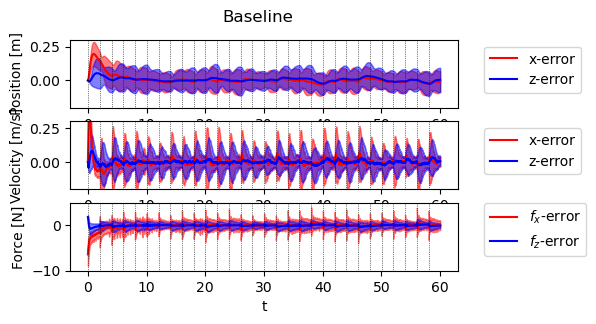

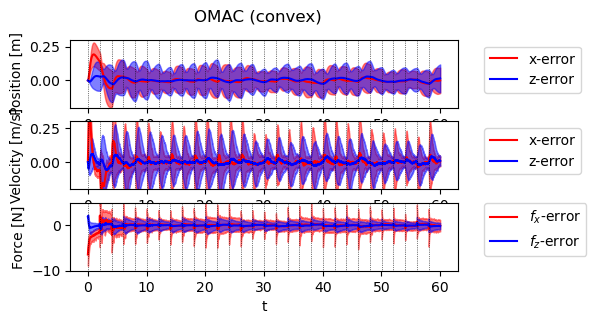

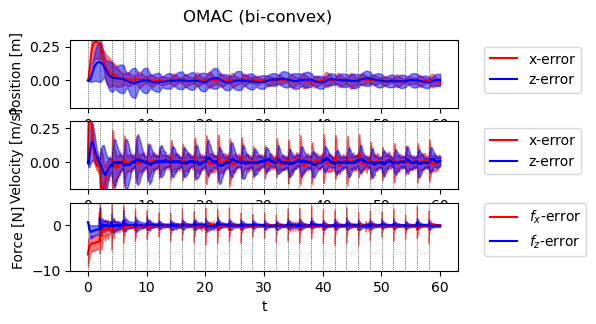

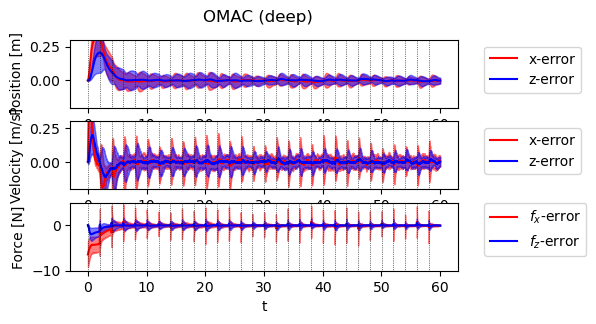

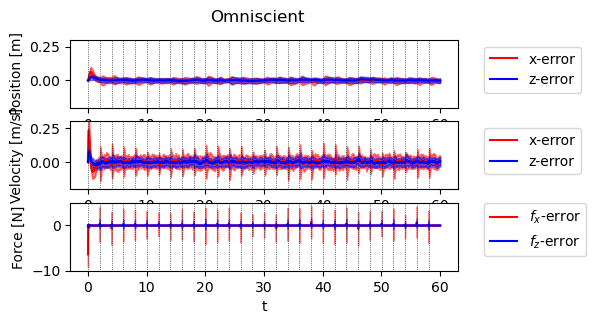

In [33]:
stats = {'p_stats': [], 'v_stats': [], 'f_stats': []}
for j, data in enumerate(Data):
    if CTRLS[j]._name == 'pid':
        stats['p_stats'].append(0.)
        stats['v_stats'].append(0.)
        stats['f_stats'].append(0.)
        continue
    
    for k, d in enumerate(data):
        if k == 0:
            p_tracker = utils.StatisticsTracker()
            v_tracker = utils.StatisticsTracker()
            f_tracker = utils.StatisticsTracker()
        p_tracker.update(err = (d['X'][:, 0:3] - d['pd']))
        v_tracker.update(err = (d['X'][:, 7:10]))
        f_tracker.update(err = (d['f_hat'][:,0,:] - d['Fs']))
    stats['p_stats'].append(p_tracker.get_statistics())
    stats['v_stats'].append(v_tracker.get_statistics())
    stats['f_stats'].append(f_tracker.get_statistics())
    

    print(CTRLS[j]._name)

    plt.figure(figsize=(5,3))

    # Plot position tracking
    plt.subplot(3,1,1)
    for i in [0, 2]: # only plot x and z
        # plt.subplot(2,3,i+1)
        mean = stats['p_stats'][j].mean[:,i]
        std = stats['p_stats'][j].std[:,i]
        plt.plot(d['t'], mean, label=xyz[i] + '-error', color = color[i])
        plt.fill_between(d['t'], mean - std, mean + std, color = color[i], alpha = 0.5 )
    plt.legend(bbox_to_anchor=(1.05, 1.))
    for t in d['t'][d['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    plt.xlabel('t')
    plt.ylabel('Position [m]')
    # plt.ylabel(xyz[i])
    plt.ylim((-0.2, 0.3))

    # Plot position tracking
    plt.subplot(3,1,2)
    for i in [0, 2]: # only plot x and z
        # plt.subplot(2,3,i+1)
        mean = stats['v_stats'][j].mean[:,i]
        std = stats['v_stats'][j].std[:,i]
        plt.plot(d['t'], mean, label=xyz[i] + '-error', color = color[i])
        plt.fill_between(d['t'], mean - std, mean + std, color = color[i], alpha = 0.5 )
    plt.legend(bbox_to_anchor=(1.05, 1.))
    for t in d['t'][d['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    plt.xlabel('t')
    plt.ylabel('Velocity [m/s]')
    # plt.ylabel(xyz[i])
    plt.ylim((-0.2, 0.3))

    # Plot force estimation
    plt.subplot(3,1,3)
    for i in [0, 2]:
        # plt.subplot(2,3,i+4)
        mean = stats['f_stats'][j].mean[:,i]
        std = stats['f_stats'][j].std[:,i]
        plt.plot(d['t'], mean, label=r'$f_' + xyz[i] + '$-error', color = color[i])
        plt.fill_between(d['t'], mean - std, mean + std, color = color[i], alpha = 0.5 )
        # plt.plot(d['t'], d['f_hat'][:,0,i], label=r'$\hat{f}_' + xyz[i] + '$', color = color[i])
    plt.legend(bbox_to_anchor=(1.05, 1.1))
    for t in d['t'][d['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    plt.xlabel('t')
    plt.ylabel('Force [N]')
    # plt.ylabel(xyz[i])
    plt.ylim((-10,5))

    plt.suptitle(CTRLS[j].name_long)
    savefig('performance-stats_' + CTRLS[j]._name)

pid
baseline-omac
baseline-omac
convex-omac
convex-omac
biconvex-omac


C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

biconvex-omac
deep-omac
deep-omac
omniscient


C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fut

omniscient


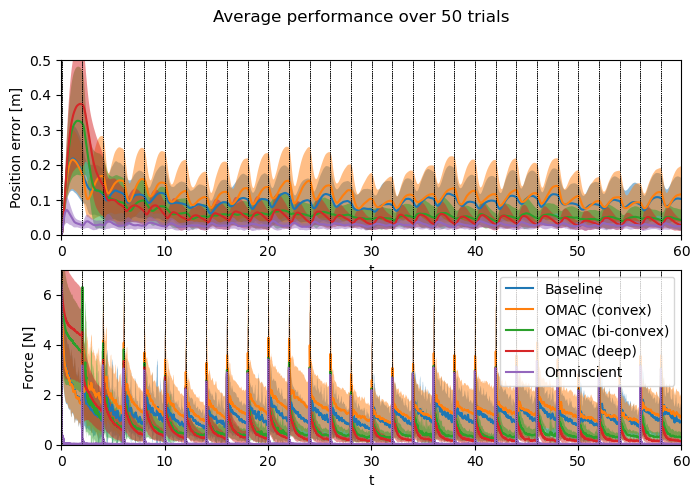

In [50]:
stats = {'p_stats': [], 'v_stats': [], 'f_stats': []}
plt.figure(figsize=(8,5))
for j, data in enumerate(Data):
    print( CTRLS[j]._name)
    if CTRLS[j]._name == 'pid':
        stats['p_stats'].append(0.)
        stats['v_stats'].append(0.)
        stats['f_stats'].append(0.)
        continue
    
    # for k, d in enumerate(data):
    #     if k == 0:
    #         p_tracker = utils.StatisticsTracker()
    #         # v_tracker = utils.StatisticsTracker()
    #         f_tracker = utils.StatisticsTracker()
    #     # p_tracker.update(err = np.sqrt(
    #     #     np.linalg.norm(d['X'][:, 0:3] - d['pd'], axis=1) ** 2 +
    #     #     np.linalg.norm(d['X'][:, 7:10], axis=1)**2))
    #     p_tracker.update(err = np.linalg.norm(d['X'][:, 0:3] - d['pd'], axis=1))
    #     # v_tracker.update(err = np.linalg.norm(d['X'][:, 7:10], axis=1))
    #     f_tracker.update(err = np.linalg.norm(d['f_hat'][:,0,:] - d['Fs'], axis=1))
    # stats['p_stats'].append(p_tracker.get_statistics())
    # # stats['v_stats'].append(v_tracker.get_statistics())
    # stats['f_stats'].append(f_tracker.get_statistics())

    for k, d in enumerate(data):
        # if k == 0:
            # Reset the statistics tracker for new controller
            
        p_tracker = utils.StatisticsTracker()
        f_tracker = utils.StatisticsTracker()
        for i, t in enumerate(d['t']):
            if d['meta_adapt_trigger']:
                # save result
                p_stats = p_tracker.get_statistics()
                f_stats = f_tracker.get_statistics()
                p_tracker.reset()
                f_tracker.reset()
            else:
                # concatenate
                p_tracker.update(np.linalg.norm(d['X'][i, 0:3] - d['pd'][i,:]))
                f_tracker.update(np.linalg.norm(d['f_hat'][i,0,:] - d['Fs'][i,:])
        p_tracker.update(err = np.linalg.norm(d['X'][:, 0:3] - d['pd'], axis=1))
        f_tracker.update(err = np.linalg.norm(d['f_hat'][:,0,:] - d['Fs'], axis=1))
    stats['p_stats'].append(p_tracker.get_statistics())
    # stats['v_stats'].append(v_tracker.get_statistics())
    stats['f_stats'].append(f_tracker.get_statistics())

    s = utils.StatisticsTracker()
    

    print(CTRLS[j]._name)


    # Plot position tracking
    plt.subplot(2,1,1)
    for i in [0,]: # only plot x and z
        # plt.subplot(2,3,i+1)
        mean = stats['p_stats'][j].mean
        std = stats['p_stats'][j].std
        plt.plot(d['t'], mean, label=CTRLS[j].name_long)
        plt.fill_between(d['t'], mean - std, mean + std, alpha = 0.5 )
    # plt.legend(bbox_to_anchor=(1.05, 1.))
    # plt.legend()
    for t in d['t'][d['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    plt.xlabel('t')
    plt.ylabel('Position error [m]')
    plt.margins(x=0)
    # plt.ylabel(xyz[i])
    plt.ylim((0.0, 0.5))
    plt.xlim((0, 60.0))

    # # Plot position tracking
    # plt.subplot(3,1,2)
    # for i in [0,]: # only plot x and z
    #     # plt.subplot(2,3,i+1)
    #     mean = stats['v_stats'][j].mean
    #     std = stats['v_stats'][j].std
    #     plt.plot(d['t'], mean, label=xyz[i] + '-error')
    #     plt.fill_between(d['t'], mean - std, mean + std, alpha = 0.5 )
    # plt.legend(bbox_to_anchor=(1.05, 1.))
    # for t in d['t'][d['meta_adapt_trigger']]:
    #     plt.axvline(t, ls=':', color='k', lw=0.5)
    # plt.xlabel('t')
    # plt.ylabel('Velocity [m/s]')
    # # plt.ylabel(xyz[i])
    # plt.ylim((-0.2, 0.3))

    # Plot force estimation
    plt.subplot(2,1,2)
    for i in [0,]:
        # plt.subplot(2,3,i+4)
        mean = stats['f_stats'][j].mean
        std = stats['f_stats'][j].std
        plt.plot(d['t'], mean, label=CTRLS[j].name_long)
        plt.fill_between(d['t'], mean - std, mean + std, alpha = 0.5 )
        # plt.plot(d['t'], d['f_hat'][:,0,i], label=r'$\hat{f}_' + xyz[i] + '$')
    # plt.legend(bbox_to_anchor=(1.05, 1.1))
    plt.legend()
    for t in d['t'][d['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    plt.xlabel('t')
    plt.ylabel('Force [N]')
    # plt.ylabel(xyz[i])
    plt.xlim((0, 60.0))
    plt.ylim((-0,7))
    plt.margins(x=0)

    plt.suptitle('Average performance over 50 trials')
    # plt.suptitle(CTRLS[j].name_long)
savefig('performance-stats-combined-position')

pid
baseline-omac
(50, 30)
convex-omac
(50, 30)
biconvex-omac


C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(50, 30)
deep-omac


C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(50, 30)
omniscient


C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(50, 30)


C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\mtoc1\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


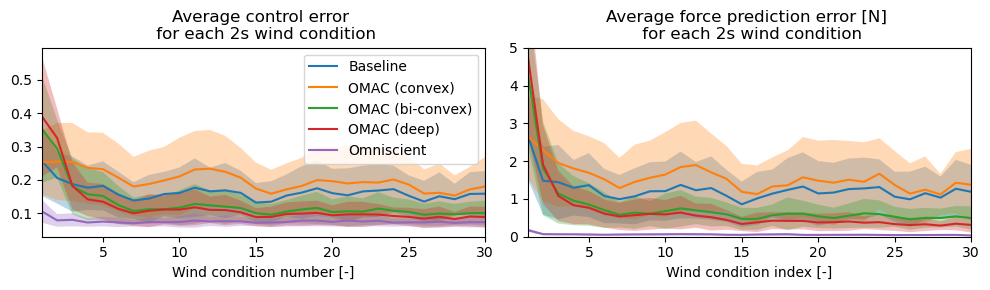

In [97]:
plt.figure(figsize=(10,3))

for j, data in enumerate(Data):
    print( CTRLS[j]._name)
    if CTRLS[j]._name == 'pid':
        stats['p_stats'].append(0.)
        stats['v_stats'].append(0.)
        stats['f_stats'].append(0.)
        continue
    
    # f_tracker = utils.StatisticsTracker()
    paves = [] # (k, m): k trial number, m is condition index
    faves = [] # (k, m): k trial number, m is condition index
    for k, d in enumerate(data): # data has 50 datasets
        paves.append([])
        faves.append([])
        # m = 0 # index in paves
        psum = 0.
        fsum = 0.
        count = 0
        for i, t in enumerate(d['t']): # loop over one dataset
            psum += np.linalg.norm(d['X'][i, [0, 1, 2, 7, 8, 9]]) # assume pd is 0
            fsum += np.linalg.norm(d['f_hat'][i,0,:] - d['Fs'][i,:])
            count += 1
            if (d['meta_adapt_trigger'][i] and i > 10) or i == len(d['t']) - 1:
                pave = psum / count
                fave = fsum / count
                count = 0

                paves[-1].append(pave)
                faves[-1].append(fave)

                psum = 0.
                fsum = 0.
                count = 0
    print(np.array(paves).shape)

    p_mean = np.mean(paves, axis=0)
    p_std = np.std(paves, axis=0)
    f_mean = np.mean(faves, axis=0)
    f_std = np.std(faves, axis=0)

    # stats['p_stats'].append(np.array(paves) / len(data))
    # # stats['f_stats'].append(f)

    plt.subplot(1,2,1)
    plt.plot(np.arange(30)+1, p_mean, label = CTRLS[j].name_long)
    plt.fill_between(np.arange(30)+1, p_mean - p_std, p_mean + p_std, alpha = 0.3)
    plt.margins(x=0)
    plt.xlabel('Wind condition number [-]')
    # plt.ylabel('ACE')
    plt.title('Average control error \n for each 2s wind condition')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(30)+1, f_mean, label = CTRLS[j].name_long)
    plt.fill_between(np.arange(30)+1, f_mean - f_std, f_mean + f_std, alpha = 0.3)
    plt.margins(x=0)
    plt.xlabel('Wind condition index [-]')
    plt.title('Average force prediction error [N] \n for each 2s wind condition')
    # plt.ylabel('Force prediction error [N]')
    plt.ylim((0,5))
    plt.tight_layout()


In [113]:
print('%15s, %6s, %15s' % ('Controller', 'ACE', 'Steady State ACE'))

err = []
err_ss = []
for j, data in enumerate(Data):
    err.append([])
    err_ss.append([])
    c = CTRLS[j]
    for k, d in enumerate(data): # data has 50 datasets
        err[-1].append(np.mean(np.linalg.norm(d['X'][:,[0, 1, 2, 7, 8, 9]], axis=1)))
        err_ss[-1].append(np.mean(np.linalg.norm(d['X'][1000:,[0, 1, 2, 7, 8, 9]], axis=1)))
        # print('%15s, %5.4f, %5.4f' % (c._name, err[-1][-1], err_ss[-1][-1]))
print(np.mean(err, axis=1), np.std(err, axis=1))
print(np.mean(err_ss, axis=1), np.std(err_ss, axis=1))

     Controller,    ACE, Steady State ACE
[0.27572881 0.16377921 0.19931187 0.12876008 0.12130341 0.07569908] [0.02378994 0.01840983 0.02594798 0.01126532 0.0132973  0.00316627]
[0.2484247  0.15610377 0.18993914 0.10889278 0.09836271 0.07431175] [0.02803678 0.01995846 0.0255415  0.01408891 0.01017254 0.00335596]


baseline-omac
0 0
convex-omac
0 1
biconvex-omac
0 2
deep-omac
0 3


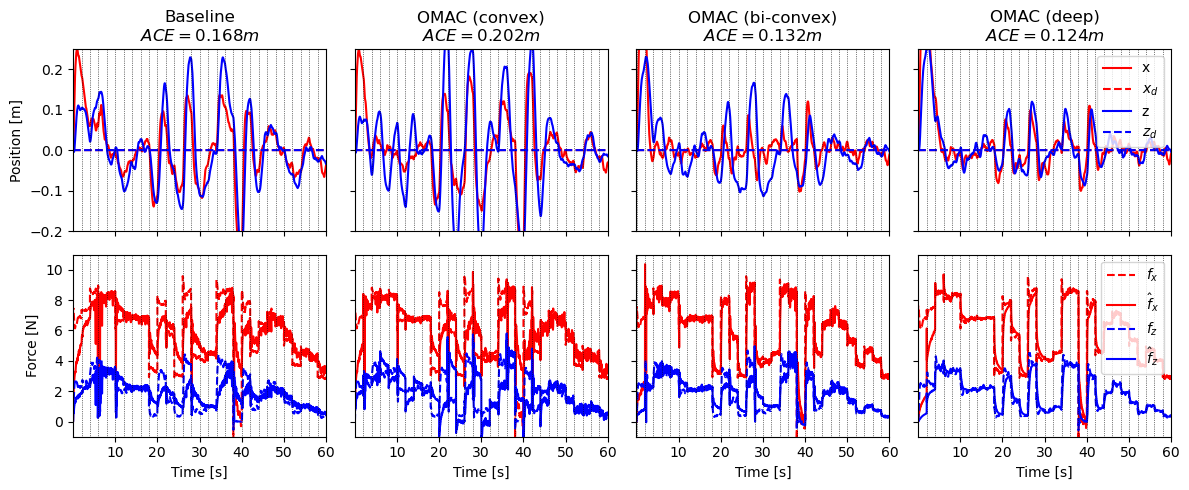

In [124]:
fig = plt.figure(figsize=(12, 5))
# gs = fig.add_gridspec(2,2)
rows = 1
cols = 4 # int(len(Data)/rows)
gs = plt.GridSpec(2 * rows, cols)
# for j, data in enumerate(Data[0:1])):
#     c = CTRLS[j]
#     for k, d in enumerate(data): # data has 50 datasets
idx = 1
for j, c in enumerate(CTRLS):
    data = Data[j][idx]
    if CTRLS[j]._name in {'pid', 'omniscient'}:
        continue
    
    print(CTRLS[j]._name)


    # Plot quadrotor
    row = 0 # int(j / cols)
    col = j - 1 # % cols
    print(row, col)

    # Plot position tracking
    ax = fig.add_subplot(gs[row*2, col])
    for i in [0, 2]: # only plot x and z
        plt.plot(data['t'], data['X'][:,i], label=xyz[i], color = color[i])
        plt.plot(data['t'], data['pd'][:,i], '--', label=r'$' + xyz[i] + '_d$', color = color[i])
    for t in data['t'][data['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)

    plt.margins(x=0)

    if j == len(Data) - 2:
        plt.legend(loc = 'upper right')
    ax.axes.xaxis.set_ticklabels([])
    if col == 0:
        plt.ylabel('Position [m]')
    else:
        ax.axes.yaxis.set_ticklabels([])
    plt.ylim((-0.2, 0.25))
    # plt.title(CTRLS[j].name_long + '\n$ACE=%.3f m$\n$ACE_{t>10s}=%.3fm$' % (err[j][idx], err_ss[j][idx]))
    plt.title(CTRLS[j].name_long + '\n$ACE=%.3f m$' % (err[j][idx], ))

    # Plot force estimation
    ax = fig.add_subplot(gs[row*2+1, col])
    for i in [0, 2]:
        plt.plot(data['t'], data['Fs'][:,i], '--', label=r'$f_' + xyz[i] + '$', color = color[i])
        if CTRLS[j]._name == 'pid':
            plt.plot(data['t'], -data['i_term'][:,i], '-', label=r'$K_i\int\tilde{p}_' + xyz[i] + 'dt$', color = color[i])
        else:
            plt.plot(data['t'], data['f_hat'][:,0,i], '-', label=r'$\hat{f}_' + xyz[i] + '$', color = color[i])
    for t in data['t'][data['meta_adapt_trigger']]:
        plt.axvline(t, ls=':', color='k', lw=0.5)
    
    plt.margins(x=0)

    if j == len(Data) - 2:
        plt.legend(loc = 'upper right')
    if row == rows-1:
        plt.xlabel('Time [s]')
    else: 
        ax.axes.xaxis.set_ticklabels([])
    if col == 0:
        plt.ylabel('Force [N]')
    else:
        ax.axes.yaxis.set_ticklabels([])
    plt.ylim((-1, 11))

plt.tight_layout()
# savefig('performance_combined_%04d' % 0)

In [119]:
for c in CTRLS:
    print(c._name)

pid
baseline-omac
convex-omac
biconvex-omac
deep-omac
omniscient


In [ ]:
for j, data in enumerate(Data):
    if CTRLS[j]._name == 'baseline':
        continue
    
    for k, d in enumerate(data):
        print(CTRLS[j]._name)

        plt.figure(figsize=(5,3))

        # Plot position tracking
        plt.subplot(2,1,1)
        for i in [0, 1, 2]: # only plot x and z
            # plt.subplot(2,3,i+1)
            plt.plot(d['t'], d['X'][:,i], label=xyz[i], color = color[i])
            plt.plot(d['t'], d['pd'][:,i], ':', label=xyz[i] + '_d', color = color[i])
            # plt.plot(d['t'], d['Vwind'][:,i], label='Vwind_' + xyz[i])
        plt.legend(bbox_to_anchor=(1.05, 1.))
        for t in d['t'][d['meta_adapt_trigger']]:
            plt.axvline(t, ls=':', color='k', lw=0.5)
        plt.xlabel('t')
        plt.ylabel('Position [m]')
        # plt.ylabel(xyz[i])
        plt.ylim((-0.2, 0.3))

        # Plot force estimation
        plt.subplot(2,1,2)
        for i in [0, 1, 2]:
            # plt.subplot(2,3,i+4)
            plt.plot(d['t'], d['Fs'][:,i], '--', label=r'$f_' + xyz[i] + '$', color = color[i])
            plt.plot(d['t'], d['f_hat'][:,0,i], label=r'$\hat{f}_' + xyz[i] + '$', color = color[i])
        plt.legend(bbox_to_anchor=(1.05, 1.1))
        for t in d['t'][d['meta_adapt_trigger']]:
            plt.axvline(t, ls=':', color='k', lw=0.5)
        plt.xlabel('t')
        plt.ylabel('Force [N]')
        # plt.ylabel(xyz[i])
        plt.ylim((-1, 11))

        plt.suptitle(CTRLS[j].name_long + ' - Trial #%i' % k)
        # savefig('xz-performance_' + CTRLS[j]._name)